## AutoEncoder(AE)
- 비지도 학습을 위한 딥러닝 모델 중 하나이다.
- Encoder, Latent Space, Decoder으로 이루어져있고, input과 Ouput값이 동일하다.
- Latent Space 그 자체를 하나의 새로운 Feature 로 사용할 수 있다.
> cf. fine tunning : Pre-Trained Model에 재학습시키는 과정을 의미한다.

## Stacked AutoEncoder(SAE)
- AutoEncoder 를 쌓아올린 모델
- AutoEncoder의 새로운 Feature가 Feature로서 의미가 있다면 이를 쌓아 올려 학습하면 더 좋은 학습 모델을 만들 수 있다고 생각한 것

## Denoising AutoEncoder
- AE와 마찬가지로 Input Data를 잘 복원하도록 학습시키는 모델이지만, Input Data에 약간의 Noise를 추가해 Robust 한 모델을 만들겠다는 의미
> SDAE 는 AE를 DAE로 변형한 후, stack을 쌓아올린 모델을 의미

In [4]:
# 모듈 import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [5]:
# gpu 사용 여부 확인
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print("torch version : {}".format(torch.__version__))
print("torch cuda available : {}".format(DEVICE))

torch version : 1.7.1+cu110
torch cuda available : cuda


In [6]:
# 배치사이즈, 에폭
BATCH_SIZE = 32
EPOCHs = 10

In [7]:
# Data 불러오기
train_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST/", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST/", train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [8]:
# Data 확인하기
for (X_train, y_train) in train_loader:
    print("X_train type : {}\nX_train size : {}\n".format(X_train.type(), X_train.size()))
    print("y_train type : {}\ny_train size : {}".format(y_train.type(), y_train.size()))
    break

X_train type : torch.FloatTensor
X_train size : torch.Size([32, 1, 28, 28])

y_train type : torch.LongTensor
y_train size : torch.Size([32])


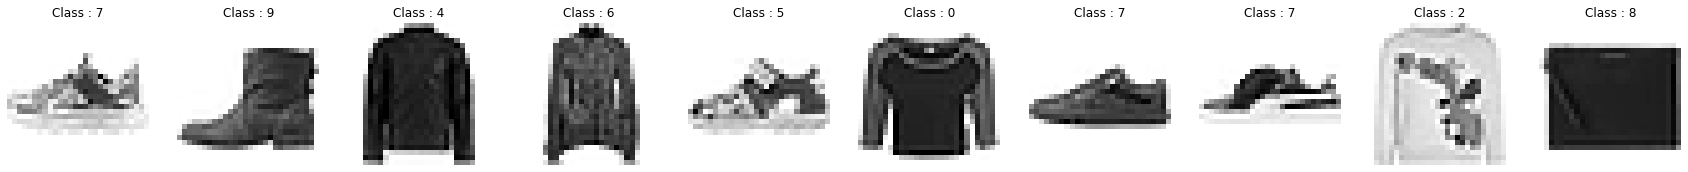

In [37]:
# 데이터 형태 확인해보기
pltsize = 3
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:2,:,:].numpy().reshape(28,28), cmap = 'gray_r')
    plt.title('Class : ' + str(y_train[i].item()))

In [40]:
# 모델 설계하기
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = self.decoder(encoded)
        encoded = self.encoder(encoded)
        encoded = self.decoder(encoded)
        encoded = self.encoder(encoded)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [41]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [42]:
# 학습을 진행하며 학습데이터에 대한 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    # 학습 상태로 지정
    model.train()
    # train_loader 에는 이미지 데이터와 label 데이터가 mini batch size로 묶여 저장돼 있다.
    for batch_idx, (image, _) in enumerate(train_loader):
        # 불러오는 이미지는 32,28,28,1 의 형태를 하고 있을 것이기 때문에, 첫 레이어에 넣기 위해 size를 조절해주고 gpu에 할당한다.
        image = image.view(-1,28*28).to(DEVICE)
        target = image.view(-1,28*28).to(DEVICE)

        # 기존에 정의한 장비에 할당했을 경우, 과거에 이용한 loss의 gradients 값이 할당되어 있기 때문에 gradient 초기화
        optimizer.zero_grad()
        encoded, decoded = model(image)
        # 계산된 Output과 target을 MSE를 이용해 Loss값 계산
        loss = criterion(decoded, target)
        # Loss 값을 계산한 결과를 바탕으로 역전파 알고리즘을 통해 계산된 Gradient 값을 각 파라미터에 할당
        loss.backward()
        # 각 파라미터에 할당된 Gradient값을 이용해 파라미터 값을 업데이트한다.
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [{} / {} ({:.0f}%)]\t".format(Epoch,batch_idx * len(image),len(train_loader.dataset), 100 * batch_idx / len(train_loader)),end = '')
            print('Train Loss : {:.6f}'.format(loss.item()))

In [43]:
# 학습을 하는 과정에서 모델의 성능을 확인할 수 있는 함수
def evaluate(model, test_loader):
    # 평가 상태 지정
    model.eval()
    # test_loss 값 계산을 위해 임시로 초기화
    test_loss = 0
    real_image = []
    gen_image = []
    
    # 파라미터 값이 업데이트되는 현상을 방지하기 위해 torch.no_grad() 메서드를 이용해 gradient의 흐름을 억제
    with torch.no_grad():
        for image,_ in test_loader:
            image = image.view(-1,28*28).to(DEVICE)
            target = image.view(-1,28*28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, image).item()
            # 실제 이미지로 할당된 이미지를 real_image 리스트에 추가
            real_image.append(image.to('cpu'))
            # 생성된 이미지를 gen_image 리스트에 추가
            gen_image.append(decoded.to('cpu'))
    
    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch : 1 [0 / 60000 (0%)]	Train Loss : 0.203906
Train Epoch : 1 [6400 / 60000 (11%)]	Train Loss : 0.063229
Train Epoch : 1 [12800 / 60000 (21%)]	Train Loss : 0.050091
Train Epoch : 1 [19200 / 60000 (32%)]	Train Loss : 0.041321
Train Epoch : 1 [25600 / 60000 (43%)]	Train Loss : 0.038206
Train Epoch : 1 [32000 / 60000 (53%)]	Train Loss : 0.040056
Train Epoch : 1 [38400 / 60000 (64%)]	Train Loss : 0.030014
Train Epoch : 1 [44800 / 60000 (75%)]	Train Loss : 0.033678
Train Epoch : 1 [51200 / 60000 (85%)]	Train Loss : 0.032027
Train Epoch : 1 [57600 / 60000 (96%)]	Train Loss : 0.035492

[EPOCH : 1], 	 Test Loss : 0.0010


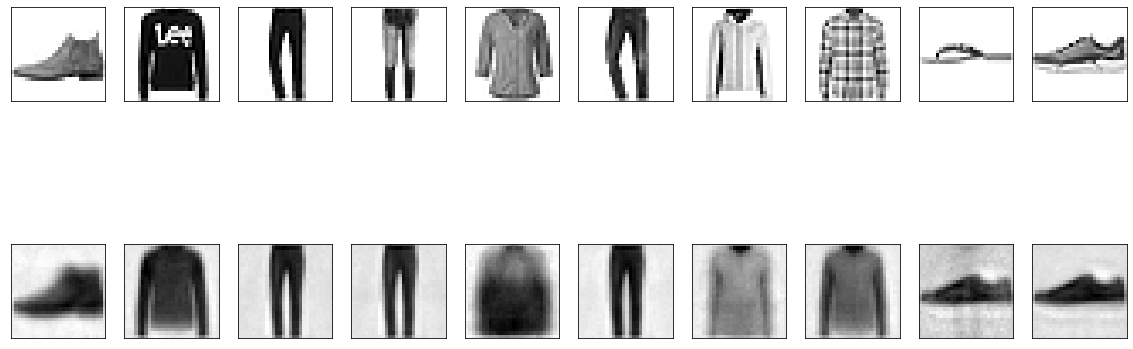

Train Epoch : 2 [0 / 60000 (0%)]	Train Loss : 0.036285
Train Epoch : 2 [6400 / 60000 (11%)]	Train Loss : 0.031274
Train Epoch : 2 [12800 / 60000 (21%)]	Train Loss : 0.032581
Train Epoch : 2 [19200 / 60000 (32%)]	Train Loss : 0.030610
Train Epoch : 2 [25600 / 60000 (43%)]	Train Loss : 0.031017
Train Epoch : 2 [32000 / 60000 (53%)]	Train Loss : 0.025954
Train Epoch : 2 [38400 / 60000 (64%)]	Train Loss : 0.023670
Train Epoch : 2 [44800 / 60000 (75%)]	Train Loss : 0.028841
Train Epoch : 2 [51200 / 60000 (85%)]	Train Loss : 0.021141
Train Epoch : 2 [57600 / 60000 (96%)]	Train Loss : 0.024118

[EPOCH : 2], 	 Test Loss : 0.0008


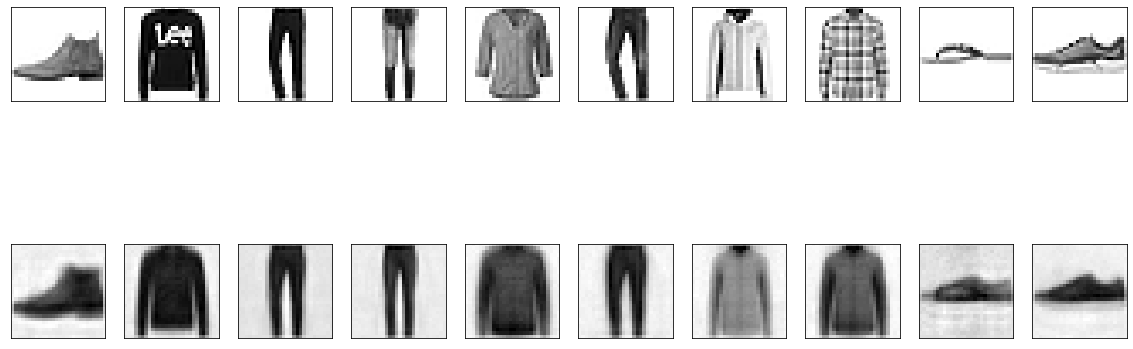

Train Epoch : 3 [0 / 60000 (0%)]	Train Loss : 0.024129
Train Epoch : 3 [6400 / 60000 (11%)]	Train Loss : 0.028940
Train Epoch : 3 [12800 / 60000 (21%)]	Train Loss : 0.025415
Train Epoch : 3 [19200 / 60000 (32%)]	Train Loss : 0.024845
Train Epoch : 3 [25600 / 60000 (43%)]	Train Loss : 0.027217
Train Epoch : 3 [32000 / 60000 (53%)]	Train Loss : 0.024699
Train Epoch : 3 [38400 / 60000 (64%)]	Train Loss : 0.026546
Train Epoch : 3 [44800 / 60000 (75%)]	Train Loss : 0.026635
Train Epoch : 3 [51200 / 60000 (85%)]	Train Loss : 0.022338
Train Epoch : 3 [57600 / 60000 (96%)]	Train Loss : 0.020831

[EPOCH : 3], 	 Test Loss : 0.0007


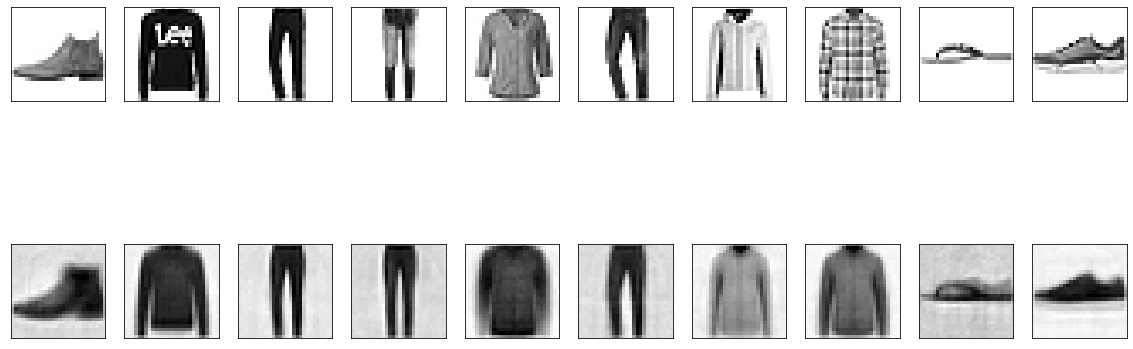

Train Epoch : 4 [0 / 60000 (0%)]	Train Loss : 0.023210
Train Epoch : 4 [6400 / 60000 (11%)]	Train Loss : 0.025386
Train Epoch : 4 [12800 / 60000 (21%)]	Train Loss : 0.023215
Train Epoch : 4 [19200 / 60000 (32%)]	Train Loss : 0.026156
Train Epoch : 4 [25600 / 60000 (43%)]	Train Loss : 0.024471
Train Epoch : 4 [32000 / 60000 (53%)]	Train Loss : 0.019282
Train Epoch : 4 [38400 / 60000 (64%)]	Train Loss : 0.024263
Train Epoch : 4 [44800 / 60000 (75%)]	Train Loss : 0.019599
Train Epoch : 4 [51200 / 60000 (85%)]	Train Loss : 0.022257
Train Epoch : 4 [57600 / 60000 (96%)]	Train Loss : 0.020710

[EPOCH : 4], 	 Test Loss : 0.0007


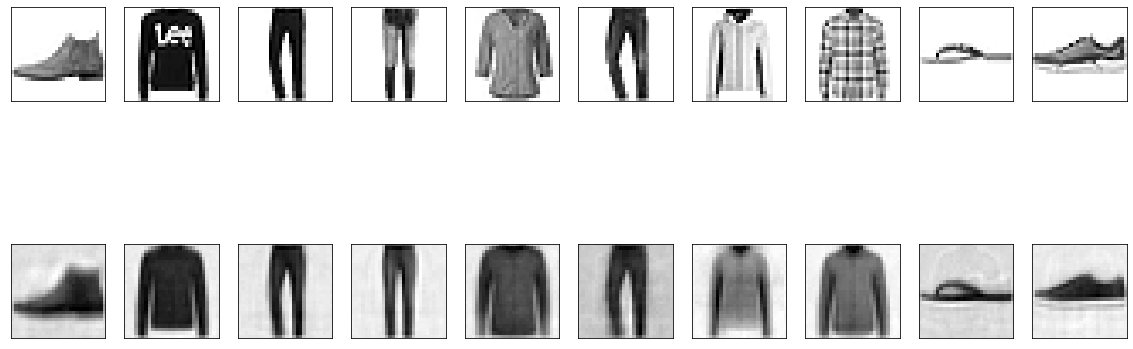

Train Epoch : 5 [0 / 60000 (0%)]	Train Loss : 0.022611
Train Epoch : 5 [6400 / 60000 (11%)]	Train Loss : 0.022525
Train Epoch : 5 [12800 / 60000 (21%)]	Train Loss : 0.021158
Train Epoch : 5 [19200 / 60000 (32%)]	Train Loss : 0.021934
Train Epoch : 5 [25600 / 60000 (43%)]	Train Loss : 0.022831
Train Epoch : 5 [32000 / 60000 (53%)]	Train Loss : 0.023173
Train Epoch : 5 [38400 / 60000 (64%)]	Train Loss : 0.022253
Train Epoch : 5 [44800 / 60000 (75%)]	Train Loss : 0.022106
Train Epoch : 5 [51200 / 60000 (85%)]	Train Loss : 0.024097
Train Epoch : 5 [57600 / 60000 (96%)]	Train Loss : 0.023724

[EPOCH : 5], 	 Test Loss : 0.0007


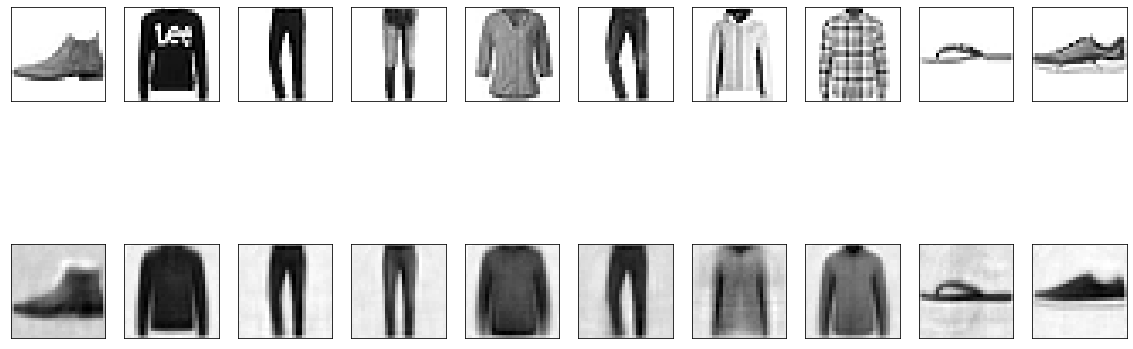

Train Epoch : 6 [0 / 60000 (0%)]	Train Loss : 0.017823
Train Epoch : 6 [6400 / 60000 (11%)]	Train Loss : 0.018138
Train Epoch : 6 [12800 / 60000 (21%)]	Train Loss : 0.022598
Train Epoch : 6 [19200 / 60000 (32%)]	Train Loss : 0.020195
Train Epoch : 6 [25600 / 60000 (43%)]	Train Loss : 0.021482
Train Epoch : 6 [32000 / 60000 (53%)]	Train Loss : 0.020415
Train Epoch : 6 [38400 / 60000 (64%)]	Train Loss : 0.017705
Train Epoch : 6 [44800 / 60000 (75%)]	Train Loss : 0.020444
Train Epoch : 6 [51200 / 60000 (85%)]	Train Loss : 0.021331
Train Epoch : 6 [57600 / 60000 (96%)]	Train Loss : 0.021648

[EPOCH : 6], 	 Test Loss : 0.0007


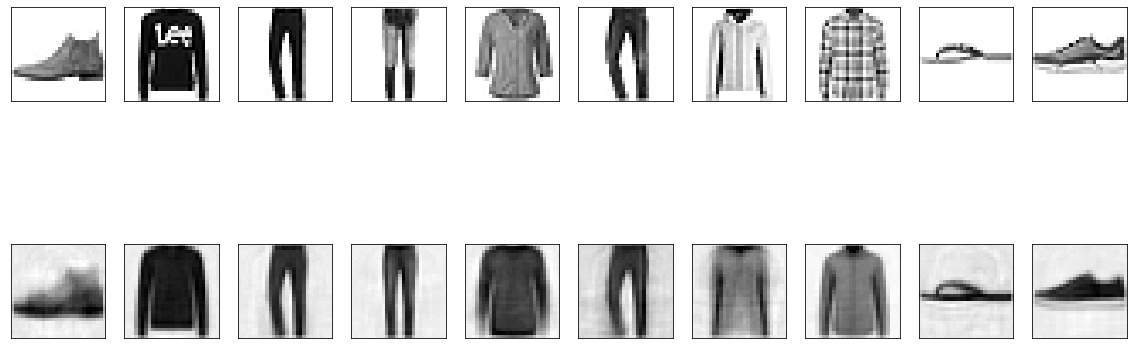

Train Epoch : 7 [0 / 60000 (0%)]	Train Loss : 0.020692
Train Epoch : 7 [6400 / 60000 (11%)]	Train Loss : 0.019360
Train Epoch : 7 [12800 / 60000 (21%)]	Train Loss : 0.022179
Train Epoch : 7 [19200 / 60000 (32%)]	Train Loss : 0.019387
Train Epoch : 7 [25600 / 60000 (43%)]	Train Loss : 0.022319
Train Epoch : 7 [32000 / 60000 (53%)]	Train Loss : 0.018814
Train Epoch : 7 [38400 / 60000 (64%)]	Train Loss : 0.020347
Train Epoch : 7 [44800 / 60000 (75%)]	Train Loss : 0.016691
Train Epoch : 7 [51200 / 60000 (85%)]	Train Loss : 0.020353
Train Epoch : 7 [57600 / 60000 (96%)]	Train Loss : 0.023021

[EPOCH : 7], 	 Test Loss : 0.0006


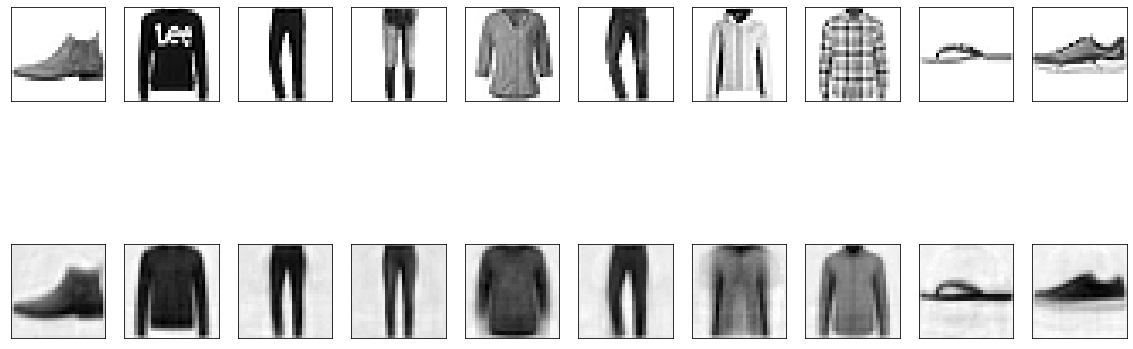

Train Epoch : 8 [0 / 60000 (0%)]	Train Loss : 0.023905
Train Epoch : 8 [6400 / 60000 (11%)]	Train Loss : 0.024389
Train Epoch : 8 [12800 / 60000 (21%)]	Train Loss : 0.019917
Train Epoch : 8 [19200 / 60000 (32%)]	Train Loss : 0.024742
Train Epoch : 8 [25600 / 60000 (43%)]	Train Loss : 0.022625
Train Epoch : 8 [32000 / 60000 (53%)]	Train Loss : 0.020556
Train Epoch : 8 [38400 / 60000 (64%)]	Train Loss : 0.019826
Train Epoch : 8 [44800 / 60000 (75%)]	Train Loss : 0.020406
Train Epoch : 8 [51200 / 60000 (85%)]	Train Loss : 0.019687
Train Epoch : 8 [57600 / 60000 (96%)]	Train Loss : 0.018336

[EPOCH : 8], 	 Test Loss : 0.0006


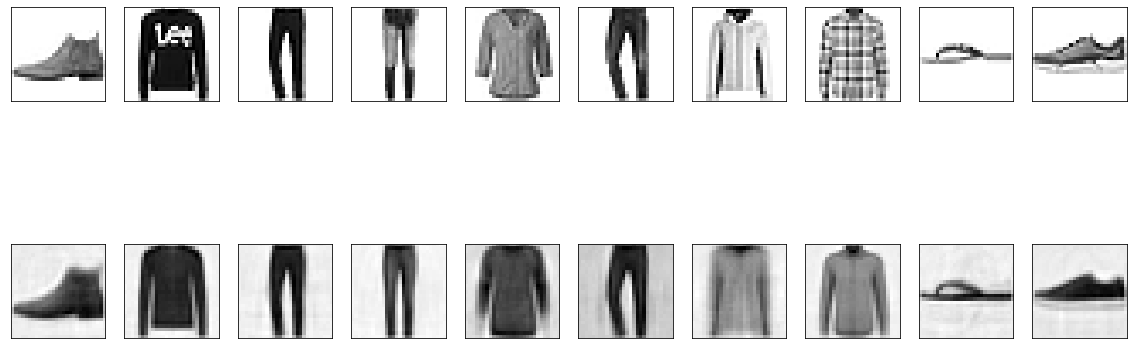

Train Epoch : 9 [0 / 60000 (0%)]	Train Loss : 0.017703
Train Epoch : 9 [6400 / 60000 (11%)]	Train Loss : 0.019499
Train Epoch : 9 [12800 / 60000 (21%)]	Train Loss : 0.018853
Train Epoch : 9 [19200 / 60000 (32%)]	Train Loss : 0.016710
Train Epoch : 9 [25600 / 60000 (43%)]	Train Loss : 0.020325
Train Epoch : 9 [32000 / 60000 (53%)]	Train Loss : 0.024577
Train Epoch : 9 [38400 / 60000 (64%)]	Train Loss : 0.022461
Train Epoch : 9 [44800 / 60000 (75%)]	Train Loss : 0.021833
Train Epoch : 9 [51200 / 60000 (85%)]	Train Loss : 0.022055
Train Epoch : 9 [57600 / 60000 (96%)]	Train Loss : 0.018284

[EPOCH : 9], 	 Test Loss : 0.0006


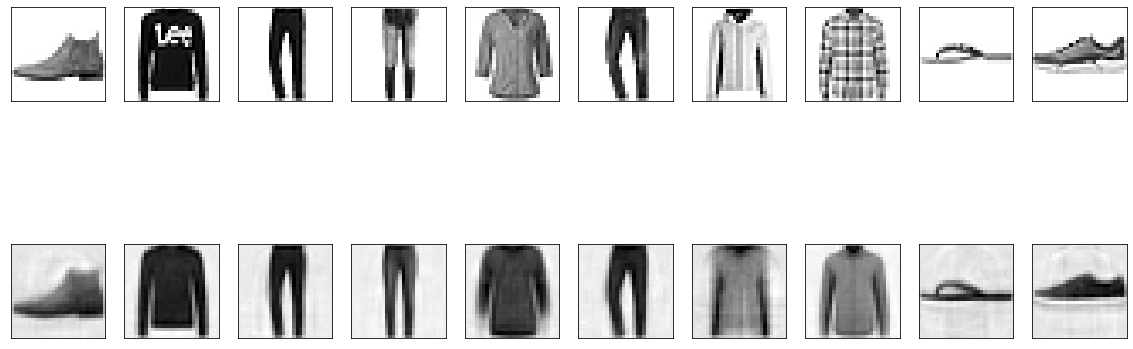

Train Epoch : 10 [0 / 60000 (0%)]	Train Loss : 0.018358
Train Epoch : 10 [6400 / 60000 (11%)]	Train Loss : 0.018295
Train Epoch : 10 [12800 / 60000 (21%)]	Train Loss : 0.018666
Train Epoch : 10 [19200 / 60000 (32%)]	Train Loss : 0.021279
Train Epoch : 10 [25600 / 60000 (43%)]	Train Loss : 0.016819
Train Epoch : 10 [32000 / 60000 (53%)]	Train Loss : 0.020375
Train Epoch : 10 [38400 / 60000 (64%)]	Train Loss : 0.018095
Train Epoch : 10 [44800 / 60000 (75%)]	Train Loss : 0.020525
Train Epoch : 10 [51200 / 60000 (85%)]	Train Loss : 0.018440
Train Epoch : 10 [57600 / 60000 (96%)]	Train Loss : 0.020869

[EPOCH : 10], 	 Test Loss : 0.0006


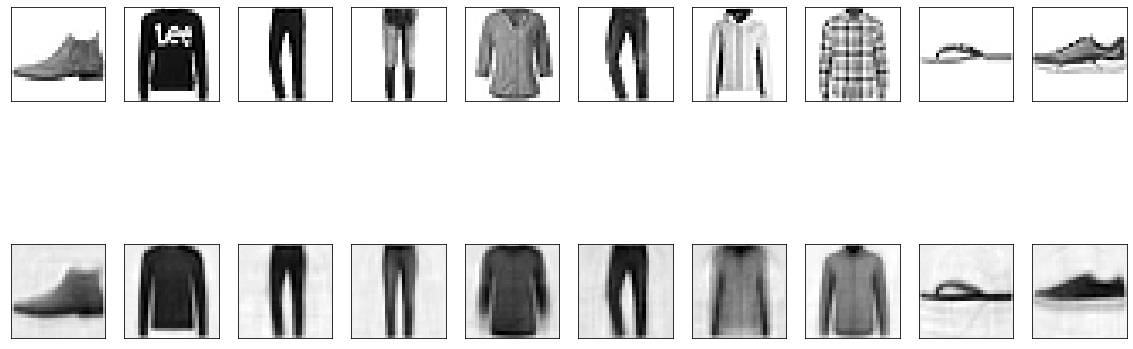

In [44]:
for Epoch in range(1,EPOCHs+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH : {}], \t Test Loss : {:.4f}".format(Epoch, test_loss))
    f,a = plt.subplots(2,10,figsize=(20,8))
    for i in range(10):
        img = np.reshape(real_image[0][i],(28,28))
        a[0][i].imshow(img,cmap = 'gray_r')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28,28))
        a[1][i].imshow(img, cmap = 'gray_r')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()